In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [4]:
block_size = 3
def build_dataset(words):
    X,Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[c] for c in context), "--->", itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

# build_dataset(words[:2])

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10
n_hidden = 300

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.numel() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

17697 parameters


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(-1, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())

    # zero the grads
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

print(loss.item())

      0/ 200000: 28.3957
  10000/ 200000: 2.6729
  20000/ 200000: 2.7654
  30000/ 200000: 2.4830
  40000/ 200000: 2.3813
  50000/ 200000: 2.3622
  60000/ 200000: 2.5245
  70000/ 200000: 2.5309
  80000/ 200000: 2.4071
  90000/ 200000: 2.8097
 100000/ 200000: 2.3312
 110000/ 200000: 2.1836
 120000/ 200000: 2.0471
 130000/ 200000: 2.0997
 140000/ 200000: 2.1365
 150000/ 200000: 1.7848
 160000/ 200000: 2.1073
 170000/ 200000: 2.1127
 180000/ 200000: 1.6674
 190000/ 200000: 1.9662
2.385958433151245


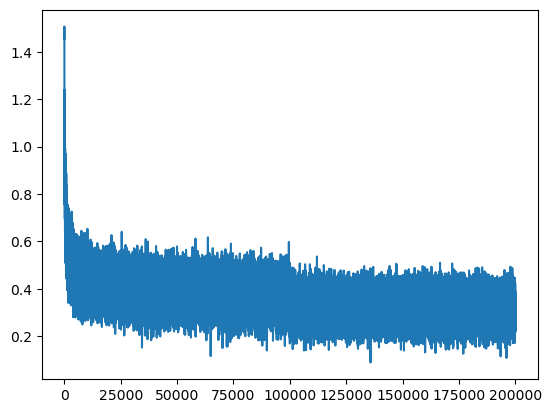

In [7]:
plt.plot(lossi);

In [8]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1271231174468994
val 2.196359157562256


In [9]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    context = [0] * block_size
    out = []
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break
    print(''.join(out))

chriah.
amelle.
khi.
mir.
rev.
cassanden.
jazon.
nadeliah.
alaeni.
nerania.
chaiiven.
leigh.
ham.
pora.
quinn.
shon.
marianni.
wayell.
dearyn.
kai.


### handling large initial loss

In [10]:
n_embd = 10
n_hidden = 300

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C,W1,b1,W2,b2]
# print(sum(p.numel() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(-1, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())

    # zero the grads
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2709
  10000/ 200000: 2.3032
  20000/ 200000: 2.3104
  30000/ 200000: 2.1828
  40000/ 200000: 2.2827
  50000/ 200000: 1.9662
  60000/ 200000: 2.4222
  70000/ 200000: 2.1511
  80000/ 200000: 1.9739
  90000/ 200000: 2.2096
 100000/ 200000: 2.1507
 110000/ 200000: 1.9934
 120000/ 200000: 1.7767
 130000/ 200000: 1.9783
 140000/ 200000: 2.0098
 150000/ 200000: 1.6559
 160000/ 200000: 2.0099
 170000/ 200000: 2.1897
 180000/ 200000: 1.5996
 190000/ 200000: 1.9166


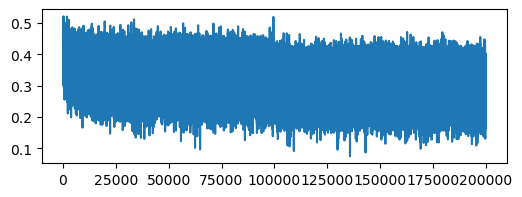

In [11]:
plt.figure(figsize=(6,2))
plt.plot(lossi);

In [12]:
split_loss('train')
split_loss('val')

train 2.021385431289673
val 2.0958995819091797


### visualizing saturations from "tanh"

In [13]:
# plt.figure(figsize=(4,2))
# plt.hist(h.view(-1).tolist(), bins=50);

In [14]:
# plt.figure(figsize=(6,2))
# plt.hist(hpreact.view(-1).tolist(), bins=50);

In [15]:
# h.abs()>0.99

In [16]:
# plt.figure(figsize=(20,5))
# plt.imshow(h.abs()>0.99, cmap='gray', interpolation='none')
# # plt.colorbar();

In [17]:
# # list = [[1,0,0.5,0,1,0],[0,1,0,1,0,1],[1,0,1,0,1,0]]
# # arr = torch.tensor(list)
# arr = torch.randn((20,20))

# plt.imshow(arr.abs()>0.9, cmap='gray', interpolation='nearest')
# plt.colorbar();

## BatchNorm

In [18]:
n_embd = 10
n_hidden = 300

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,b1,W2,b2, bngain, bnbias]
# print(sum(p.numel() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # mini-batch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(-1, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())

    # zero the grads
    for p in parameters:
        p.grad = None
    
    # backward pass
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2678
  10000/ 200000: 2.2873
  20000/ 200000: 2.4097
  30000/ 200000: 2.2592
  40000/ 200000: 2.2343
  50000/ 200000: 1.9914
  60000/ 200000: 2.4385
  70000/ 200000: 2.1801
  80000/ 200000: 2.0651
  90000/ 200000: 2.3233
 100000/ 200000: 2.2719
 110000/ 200000: 2.0728
 120000/ 200000: 1.8386
 130000/ 200000: 2.0631
 140000/ 200000: 2.1560
 150000/ 200000: 1.8420
 160000/ 200000: 2.0713
 170000/ 200000: 2.0875
 180000/ 200000: 1.6663
 190000/ 200000: 1.9509


In [19]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.044954538345337
val 2.0984561443328857
